# **Introduzione**


In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab import drive
import os
import copy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
EPOCHS = 75
INIT_LR = 1e-3
BS = 64
IMAGE_DIMS = (150, 150, 1)

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense

def model_old(dropout):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  if dropout is not 0:
    model.add(Dropout(dropout))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [0]:
def plot_acc_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()


def best_epoch(history):      # to see when validation stop to get any better
  x = history.history['val_loss']
  k = 3
  trend = []
  stop = 0
  for i in range(k,len(x)-k):
    if stop == 0:
      num = 0
      for j in range(-k, k+1):
        num = x[i+j] + num
      if len(trend) == 0:
        trend.append(num/(2*k+1))
      elif num/(2*k+1) <= trend[len(trend)-1] + 0.005:
        trend.append(num/(2*k+1))
      else:
        stop = 1
  print(2*k+len(trend))

## Formulazione delle variabili:
Si rimuovono le immagini di tessuto sano e si da ai tensori la forma (2676, 150, 150, 1), e riscalando i valori del pixel RGB (da 0 a 65535), affinché siano tra 0 e 1. We also declare new variable for training and validation
to be used when augmentation and pre-trained will come into play.
Let's notice that Assignment statements do not copy objects, they create bindings between a target and an object. We use deepcopy since we want a new variable to modify without automatically modifying the original at the same time

In [7]:
drive.mount('/content/drive/')
out_path = "/content/drive/My Drive/CompIntProjects_Paiano/FinalProject2019/numpy data/"

def load_data():
  train_images = np.load(os.path.join(out_path,'train_tensor.npy'))
  train_labels = np.load(os.path.join(out_path,'train_labels.npy'))
  test_images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  test_labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  train_images = train_images.astype('float32') / 65535   #BW 16-bit, normalization
  train_images = train_images.reshape((len(train_images), 150, 150, 1))
  test_images = test_images.astype('float32') / 65535
  test_images = test_images.reshape((len(test_images), 150, 150, 1))
  return train_images, train_labels, test_images, test_labels


def abnormal_variables():   # remove healthy patch
  train_images, train_labels, test_images, test_labels = load_data()
  train_images = train_images[1:len(train_images):2]
  train_labels = train_labels[1:len(train_labels):2]
  test_images = test_images[1:len(test_images):2]
  test_labels = test_labels[1:len(test_labels):2]
  return train_images, train_labels, test_images, test_labels


def augment(train_images, train_labels):
  np.random.seed(5)  
  np.random.shuffle(train_images)
  np.random.seed(5) 
  np.random.shuffle(train_labels)
  PERCENTAGE_VALIDATION = 0.2
  num_validation_samples = round(len(train_labels)*PERCENTAGE_VALIDATION)
  my_val_images = copy.deepcopy(train_images[:num_validation_samples])
  my_val_labels = copy.deepcopy(train_labels[:num_validation_samples])
  my_train_images = copy.deepcopy(train_images[num_validation_samples:])
  my_train_labels = copy.deepcopy(train_labels[num_validation_samples:])
  return my_train_images, my_train_labels, my_val_images, my_val_labels

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Classificare in due classi**

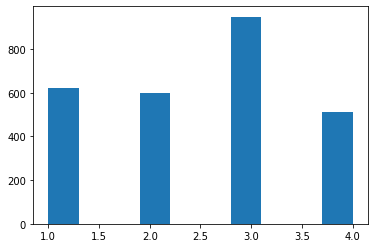

In [0]:
# we divide in two groups: mass (0) and calcification (1)
def labels_in_two(labels):
  for i in range(0,len(labels)):
    if labels[i] > 0 and labels[i] < 3 :
      labels[i] = 0
    else :
      labels[i] = 1

train_images_2, train_labels_2, test_images_2, test_labels_2 = abnormal_variables()
plt.hist(train_labels_2)    # we show samples distribution
plt.show()

labels_in_two(train_labels_2)
labels_in_two(test_labels_2)

## 2.1 - FITTING WITHOUT AUGMENTATION

In [0]:
# BUILDING THE MODEL

model = model_old(0)
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
opt = Adam(lr=INIT_LR)
model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
EPOCH = 35
history = model.fit(train_images_2, 
                      train_labels_2, 
                      epochs = EPOCH, 
                      batch_size = BS,
                      validation_split = 0.2,
                      shuffle = True)


Train on 2140 samples, validate on 536 samples
Epoch 1/35
2140/2140 [==============================] - 11s 5ms/step - loss: 0.6843 - acc: 0.5692 - val_loss: 0.8647 - val_acc: 0.0000e+00
Epoch 2/35
2140/2140 [==============================] - 3s 2ms/step - loss: 0.6784 - acc: 0.5720 - val_loss: 0.9409 - val_acc: 0.0261
Epoch 3/35
2140/2140 [==============================] - 3s 2ms/step - loss: 0.6665 - acc: 0.5874 - val_loss: 0.6284 - val_acc: 0.7854
Epoch 4/35
2140/2140 [==============================] - 3s 2ms/step - loss: 0.6575 - acc: 0.6126 - val_loss: 0.9469 - val_acc: 0.1847
Epoch 5/35
2140/2140 [==============================] - 3s 2ms/step - loss: 0.6168 - acc: 0.6921 - val_loss: 0.9638 - val_acc: 0.3134
Epoch 6/35
2140/2140 [==============================] - 3s 2ms/step - loss: 0.5710 - acc: 0.7290 - val_loss: 0.7834 - val_acc: 0.5784
Epoch 7/35
2140/2140 [==============================] - 3s 2ms/step - loss: 0.5413 - acc: 0.7533 - val_loss: 0.8031 - val_acc: 0.5802
Epoch 8/3

In [0]:
test_loss, test_acc = model.evaluate(test_images_2, test_labels_2)
print('test_acc: ', test_acc)

336/336 [==============================] - 0s 1ms/step
test_acc:  0.8095238208770752


In [0]:
#save_dir = "/content/drive/My Drive/CompIntProjects/2classes"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'2classes_scratch.h5'))

20


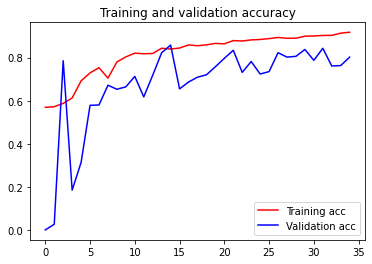

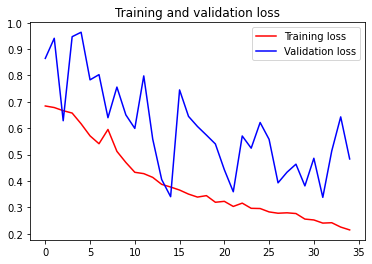

In [0]:
best_epoch(history)
plot_acc_loss(history)

## 2.1 - FITTING WITH AUGMENTATION

In [0]:
my_train_images, my_train_labels, my_val_images, my_val_labels = augment(train_images_2,train_labels_2)

aug2 = ImageDataGenerator(rotation_range = 20,                          
                          shear_range = 0.3,
                          zoom_range = 0.5, 
                          height_shift_range = 0.1, 
                          width_shift_range = 0.1,
                          horizontal_flip = True,
                          vertical_flip = True,
                          fill_mode = 'nearest')

In [0]:
model = model_old(0.5)
EPOCH_AUG_2 = 100

#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCH_AUG_2)
opt = Adam(lr=INIT_LR)
model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['acc'])

# This time we won't have "validation split", as in "fit": that's why
# we had "manually" mixed up samples and kept aside a validation set
history = model.fit_generator(
      aug2.flow(my_train_images,my_train_labels,batch_size = BS),
      validation_data = (my_val_images,my_val_labels),
      steps_per_epoch = len(my_train_labels) // BS,
      epochs = EPOCH_AUG_2)

Epoch 1/100
33/33 [==============================] - 4s 135ms/step - loss: 0.6988 - acc: 0.5229 - val_loss: 0.6871 - val_acc: 0.5514
Epoch 2/100
33/33 [==============================] - 4s 134ms/step - loss: 0.6893 - acc: 0.5431 - val_loss: 0.6864 - val_acc: 0.5514
Epoch 3/100
33/33 [==============================] - 4s 131ms/step - loss: 0.6853 - acc: 0.5431 - val_loss: 0.6820 - val_acc: 0.5383
Epoch 4/100
33/33 [==============================] - 4s 129ms/step - loss: 0.6774 - acc: 0.5893 - val_loss: 0.6921 - val_acc: 0.5327
Epoch 5/100
33/33 [==============================] - 4s 131ms/step - loss: 0.6765 - acc: 0.5946 - val_loss: 0.6631 - val_acc: 0.5682
Epoch 6/100
33/33 [==============================] - 4s 130ms/step - loss: 0.6879 - acc: 0.5782 - val_loss: 0.6695 - val_acc: 0.5907
Epoch 7/100
33/33 [==============================] - 4s 131ms/step - loss: 0.6523 - acc: 0.6283 - val_loss: 0.6384 - val_acc: 0.6673
Epoch 8/100
33/33 [==============================] - 4s 128ms/step - 

In [0]:
test_loss, test_acc = model.evaluate(test_images_2, test_labels_2)
print('test_acc: ', test_acc)

336/336 [==============================] - 0s 552us/step
test_acc:  0.875


52


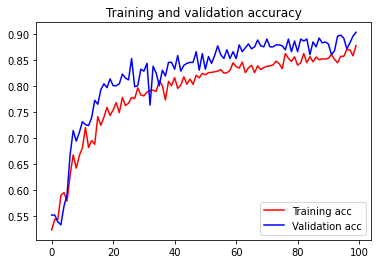

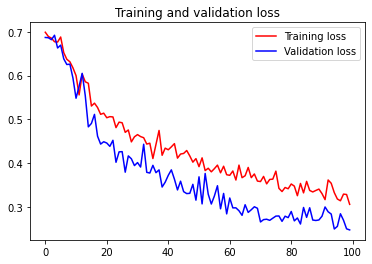

In [0]:
best_epoch(history)
plot_acc_loss(history)

In [0]:
#save_dir = "/content/drive/My Drive/CompIntProjects/2classes"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'2classes_aug.h5'))

## 3.1 - ADDING PRE-TRAINED NETWORK

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We repeat the tensor on three output, 
# for this is the input our pre-trained network wants
my_train_images_pre = copy.deepcopy(my_train_images.repeat(repeats = 3, axis = 3))
my_train_labels_pre = copy.deepcopy(my_train_labels)

my_val_images_pre = copy.deepcopy(my_val_images.repeat(repeats = 3, axis = 3))
my_val_labels_pre = copy.deepcopy(my_val_labels)

test_images_pre = copy.deepcopy(test_images_2.repeat(repeats = 3, axis = 3))
test_labels_pre = copy.deepcopy(test_labels_2)

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.0001),
              metrics = ['acc'])

# Layers Freezing
print('Number of total trainable weights: ', len(model.trainable_weights))
conv_base.trainable = False
print('Trainable weights after freezing the conv base: ', len(model.trainable_weights))

Number of total trainable weights:  30
Trainable weights after freezing the conv base:  4


In [0]:
EPOCH_TRAINED = 30      # not too many since it's already trained
history = model.fit_generator(
                      aug2.flow(my_train_images_pre,my_train_labels_pre,batch_size = BS),
                      validation_data = (my_val_images_pre,my_val_labels_pre),
                      steps_per_epoch = len(my_train_labels_pre) // BS,
                      epochs = EPOCH_TRAINED,
                      validation_steps = len(my_val_labels_pre) // BS,
                      shuffle = True)

Epoch 1/30
33/33 [==============================] - 11s 347ms/step - loss: 0.7122 - acc: 0.5335 - val_loss: 0.6132 - val_acc: 0.6262
Epoch 2/30
33/33 [==============================] - 11s 331ms/step - loss: 0.6468 - acc: 0.6052 - val_loss: 0.5392 - val_acc: 0.7084
Epoch 3/30
33/33 [==============================] - 11s 329ms/step - loss: 0.6219 - acc: 0.6524 - val_loss: 0.5395 - val_acc: 0.7794
Epoch 4/30
33/33 [==============================] - 11s 321ms/step - loss: 0.5392 - acc: 0.7338 - val_loss: 0.3781 - val_acc: 0.8393
Epoch 5/30
33/33 [==============================] - 11s 327ms/step - loss: 0.4700 - acc: 0.7950 - val_loss: 0.3632 - val_acc: 0.8355
Epoch 6/30
33/33 [==============================] - 11s 321ms/step - loss: 0.4337 - acc: 0.8199 - val_loss: 0.3124 - val_acc: 0.8636
Epoch 7/30
33/33 [==============================] - 10s 315ms/step - loss: 0.3992 - acc: 0.8276 - val_loss: 0.3175 - val_acc: 0.8598
Epoch 8/30
33/33 [==============================] - 10s 307ms/step - 

In [0]:
test_loss, test_acc = model.evaluate(test_images_pre, test_labels_pre)
print('test_acc: ', test_acc)

336/336 [==============================] - 0s 1ms/sample - loss: 0.2534 - acc: 0.8780
test_acc:  0.8779762


20


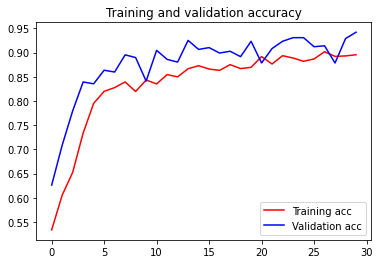

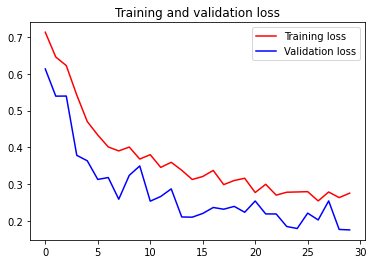

In [0]:
best_epoch(history)
plot_acc_loss(history)

In [0]:
#save_dir = "/content/drive/My Drive/CompIntProjects/2classes"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'2classes_pre_trained.h5'))

In [0]:
from tensorflow.keras.models import load_model
save_dir = "/content/drive/My Drive/CompIntProjects/2classes"
model_old = load_model(os.path.join(save_dir,"2classes_pre_trained.h5"))
test_loss, test_acc = model_old.evaluate(test_images_pre, test_labels_pre)
print('test_acc: ', test_acc)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
336/336 [==============================] - 1s 2ms/sample - loss: 0.2434 - acc: 0.9018
test_acc:  0.90178573


### *Fine-Tuning*

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1' or 'block2_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.0001),
              metrics = ['acc'])

history = model.fit_generator(
            aug2.flow(my_train_images_pre,my_train_labels_pre,batch_size = BS),
            validation_data = (my_val_images_pre,my_val_labels_pre),
            steps_per_epoch = len(my_train_labels_pre) // BS,
            epochs = 10,
            validation_steps = len(my_val_labels_pre) // BS,
            shuffle = True)

Epoch 1/10
33/33 [==============================] - 11s 335ms/step - loss: 0.2309 - acc: 0.9013 - val_loss: 0.1939 - val_acc: 0.9121
Epoch 2/10
33/33 [==============================] - 11s 323ms/step - loss: 0.2362 - acc: 0.9085 - val_loss: 0.1655 - val_acc: 0.9421
Epoch 3/10
33/33 [==============================] - 10s 312ms/step - loss: 0.2224 - acc: 0.9148 - val_loss: 0.1600 - val_acc: 0.9383
Epoch 4/10
33/33 [==============================] - 10s 318ms/step - loss: 0.2091 - acc: 0.9167 - val_loss: 0.1723 - val_acc: 0.9271
Epoch 5/10
33/33 [==============================] - 10s 314ms/step - loss: 0.2133 - acc: 0.9157 - val_loss: 0.1744 - val_acc: 0.9402
Epoch 6/10
33/33 [==============================] - 10s 307ms/step - loss: 0.2134 - acc: 0.9182 - val_loss: 0.1893 - val_acc: 0.9215
Epoch 7/10
33/33 [==============================] - 10s 314ms/step - loss: 0.2052 - acc: 0.9206 - val_loss: 0.1665 - val_acc: 0.9439
Epoch 8/10
33/33 [==============================] - 11s 318ms/step - 

In [0]:
test_loss, test_acc = model.evaluate(test_images_pre, test_labels_pre)
print('test_acc: ', test_acc)

336/336 [==============================] - 0s 1ms/sample - loss: 0.2558 - acc: 0.9048
test_acc:  0.9047619


10


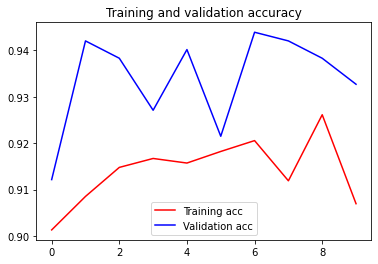

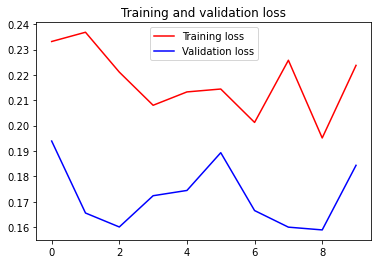

In [0]:
best_epoch(history)
plot_acc_loss(history)

In [0]:
#save_dir = "/content/drive/My Drive/CompIntProjects/2classes"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'2classes_fine.h5'))

# **Classificare in quattro classi**

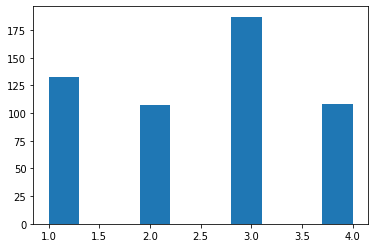

In [8]:
from tensorflow.keras.utils import to_categorical
# We will use categorical instead of binary since classes are four, not two:
# since to_categorical wants integers from 0 to num_classes - 1, we'll fix that 
def labels_in_four(labels):
  for i in range(0,len(labels)):
    labels[i] = labels[i] - 1
  return to_categorical(labels, num_classes = 4)


train_images_4, train_labels_4, test_images_4, test_labels_4 = abnormal_variables()
my_train_images_4, my_train_labels_4, my_val_images_4, my_val_labels_4 = augment(train_images_4, train_labels_4)
plt.hist(my_val_labels_4)       # we show augmented distribution mimic the real one
plt.show()
my_train_labels_4 = labels_in_four(my_train_labels_4)
my_val_labels_4 = labels_in_four(my_val_labels_4)
test_labels_4 = labels_in_four(test_labels_4)


aug4 = ImageDataGenerator(rotation_range = 20,                          
                          shear_range = 0.3,
                          zoom_range = 0.5, 
                          height_shift_range = 0.1, 
                          width_shift_range = 0.1,
                          horizontal_flip = True,
                          vertical_flip = True,
                          fill_mode = 'nearest')

## 2.2 - AUGMENTED

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(173, activation='relu'))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='sigmoid'))

model.compile(loss = 'categorical_crossentropy',
               optimizer = optimizers.Adam(lr = 0.0001),
               metrics = ['acc'])

In [0]:
EPOCH_AUG_4 = 75
history = model.fit_generator(
      aug4.flow(my_train_images_4,my_train_labels_4,batch_size = BS),
      validation_data = (my_val_images_4,my_val_labels_4),
      steps_per_epoch = len(my_train_labels_4) // BS,
      epochs = EPOCH_AUG_4,
      validation_steps = len(my_val_labels_4) // BS,
      shuffle = True)

Epoch 1/500
33/33 [==============================] - 5s 138ms/step - loss: 1.3707 - acc: 0.3327 - val_loss: 1.3856 - val_acc: 0.3495
Epoch 2/500
33/33 [==============================] - 4s 129ms/step - loss: 1.3659 - acc: 0.3539 - val_loss: 1.3727 - val_acc: 0.3495
Epoch 3/500
33/33 [==============================] - 4s 130ms/step - loss: 1.3629 - acc: 0.3534 - val_loss: 1.3688 - val_acc: 0.3495
Epoch 4/500
33/33 [==============================] - 4s 127ms/step - loss: 1.3557 - acc: 0.3611 - val_loss: 1.3645 - val_acc: 0.3495
Epoch 5/500
33/33 [==============================] - 4s 127ms/step - loss: 1.3581 - acc: 0.3471 - val_loss: 1.3680 - val_acc: 0.3495
Epoch 6/500
33/33 [==============================] - 4s 127ms/step - loss: 1.3514 - acc: 0.3558 - val_loss: 1.3790 - val_acc: 0.3495
Epoch 7/500
33/33 [==============================] - 4s 129ms/step - loss: 1.3522 - acc: 0.3603 - val_loss: 1.3659 - val_acc: 0.3495
Epoch 8/500
33/33 [==============================] - 4s 128ms/step - 

In [0]:
test_loss, test_acc = model.evaluate(test_images_4, test_labels_4)
print('test_acc: ', test_acc)
best_epoch(history)
plot_acc_loss(history)

In [0]:
#save_dir = "/content/drive/My Drive/CompIntProjects/4classes"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'4classes_aug.h5'))

## 3.2 - **PRE-TRAINED with FINE-TUNING**

In [0]:
my_train_images_fine_4 = copy.deepcopy(my_train_images_4.repeat(repeats = 3, axis = 3))
my_val_images_fine_4 = copy.deepcopy(my_val_images_4.repeat(repeats = 3, axis = 3))
test_images_fine_4 = copy.deepcopy(test_images_4.repeat(repeats = 3, axis = 3))
my_train_labels_fine_4 = copy.deepcopy(my_train_labels_4)
my_val_labels_fine_4 = copy.deepcopy(my_val_labels_4)
test_labels_fine_4 = copy.deepcopy(test_labels_4)

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

EPOCH_TRAINED = 40

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='sigmoid'))

conv_base.trainable = False

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block1_conv1' or 'block2_conv1' or 'block3_conv1' or 'block4_conv1' or 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr = 0.0001),
               metrics = ['acc'])


In [14]:
EPOCH_AUG_4 = 40
history = model.fit_generator(
      aug4.flow(my_train_images_fine_4,my_train_labels_fine_4,batch_size = BS),
      validation_data = (my_val_images_fine_4,my_val_labels_fine_4),
      steps_per_epoch = len(my_train_labels_fine_4) // BS,
      epochs = EPOCH_AUG_4,
      validation_steps = len(my_val_labels_fine_4) // BS,
      shuffle = True)

Epoch 1/40
33/33 [==============================] - 32s 964ms/step - loss: 1.4273 - acc: 0.3303 - val_loss: 1.3397 - val_acc: 0.3495
Epoch 2/40
33/33 [==============================] - 30s 900ms/step - loss: 1.2655 - acc: 0.3857 - val_loss: 1.1909 - val_acc: 0.4598
Epoch 3/40
33/33 [==============================] - 30s 901ms/step - loss: 1.1814 - acc: 0.4593 - val_loss: 1.3800 - val_acc: 0.3477
Epoch 4/40
33/33 [==============================] - 30s 899ms/step - loss: 1.1531 - acc: 0.4540 - val_loss: 1.0225 - val_acc: 0.5271
Epoch 5/40
33/33 [==============================] - 30s 901ms/step - loss: 1.0515 - acc: 0.5200 - val_loss: 0.8667 - val_acc: 0.5589
Epoch 6/40
33/33 [==============================] - 30s 901ms/step - loss: 1.0000 - acc: 0.5349 - val_loss: 0.8965 - val_acc: 0.5757
Epoch 7/40
33/33 [==============================] - 30s 900ms/step - loss: 1.0291 - acc: 0.5224 - val_loss: 0.8486 - val_acc: 0.5869
Epoch 8/40
33/33 [==============================] - 30s 899ms/step - 

336/336 [==============================] - 2s 5ms/sample - loss: 0.8033 - acc: 0.6131
test_acc:  0.6130952
12


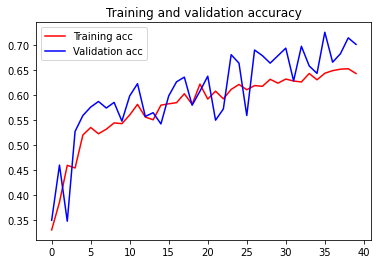

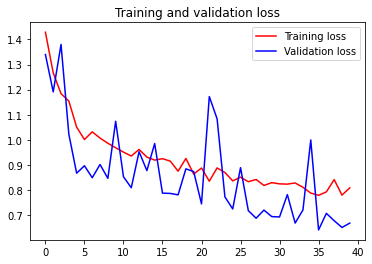

In [15]:
test_loss, test_acc = model.evaluate(test_images_fine_4, test_labels_fine_4)
print('test_acc: ', test_acc)
best_epoch(history)
plot_acc_loss(history)

In [0]:
#save_dir = "/content/drive/My Drive/CompIntProjects/4classes"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'4classes_fine.h5'))